# Clustering
Clustering attempts to group objects together based on similarity. Clustering achieves this without using any labels, comparing how similar the data for one observation is to data for other observations and groups. 

Example: Clustering can group fraudulent transactions together, seperating them from normal transactions. 

If we have only a few labels for observations in our dataset, we could use clustering to group the observations first (without labels). Then, we could **transfer** the labels of the few labeled observations to the rest of the observations within the same group. 

Ths is a form of **transfer learning**. 

In [3]:
import numpy as np
import pandas as pd

import os, time, pickle, gzip 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score

In [12]:
# Loading MNIST Dataset
file = './datasets/mnist_data/mnist.pkl.gz'

In [14]:
f = gzip.open(file, "rb")
train_set, validation_set, test_set = pickle.load(f, encoding="latin1")
f.close()

In [19]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [22]:
# Indexes for pandas
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

In [27]:
# Converting to pandas
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)

Before appling clustering algorithms we will apply dimensionality reduction algorithms to our data. We will specifically use PCA. 

*remember: dimensionality reduction algorithms capture salient information while reducing the size of the dataset. As we move from a high number of dimensions to a lower number, the noise in the dataset is minimized. PCA will capture the most important aspects of the original data and cannot devote attention to infrequently occuring elements (noise).*

In [29]:
# PCA
from sklearn.decomposition import PCA

In [30]:
# Hyper parameters
n_component = 784
whiten = False
random_state = 2018

In [31]:
# Instantiating model
pca = PCA(n_components=n_component, whiten=whiten, random_state=random_state)

In [32]:
# Let's apply PCA 
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

# k-Means
The objective of clustering is to identify distinct groups in a dataset such that the observations within a group are similar to each other but different from observation in other groups. 

In *k-Means* clustering, we specify the number of desired clusters ```k```, and the algorithm will assign each observation to exactly one of these k clusters. 

The algorithm optimizes the groups by minimizing the **within-cluster variation** (the *inertia*) such taht the sum of the within-cluster variations across all k-clusters is as small as possible.

Different runs of k-means will result in slightly different cluster assignments because k-means randomly assigns each observation to one of the k-clusters to kick off the clustering process. 

After this random initialization, k-means reassigns the observations to different clusters it attempts to minimize the Euclidean distance between each observaton and its cluster's center point (centroid). 

k-means algorithm does several runs and chooses the run that has the best seperation, defined as the lowest total sum of within cluster variation across all k-clusters. 

## k-Means Inertia
We need to set the number of clusters we would like ```n_clusters```, the number of initializations we would like to perform ```n_inits```, the maximum number of iterations the algorithm will run to reassign observations to minimize inertia ```max_iter```, and the tolerance to declare convergence ```tol```.

In [33]:
from sklearn.cluster import KMeans

In [34]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

In [35]:
k_mean_inertia = pd.DataFrame(data=[], index=range(2,21), columns=['inertia'])

In [43]:
# Testing out number of clusters and performance
for n_clusters in range(2,21):
    
    # Initliaze per loop
    k_means = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
    cutoff = 99
    k_means.fit(X_train_PCA.loc[:,0:cutoff])
    k_mean_inertia.loc[n_clusters] = k_means.inertia_

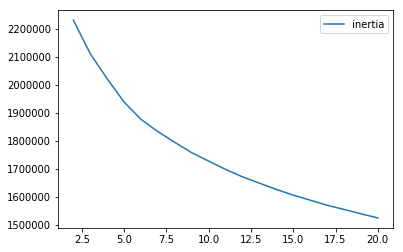

In [44]:
k_mean_inertia.plot()

In [51]:
# Defining our analyzation function
def analyze_cluster(cluster_DF, labels_DF):
    # counting number of observations in each cluster
    count_by_cluster = pd.DataFrame(data=cluster_DF['cluster'].value_counts())
    count_by_cluster.reset_index(inplace=True,drop=False)
    count_by_cluster.columns = ['cluster', 'cluster_count']
    
    # joining clusterdf with true labels
    preds = pd.concat([labels_DF,cluster_DF], axis=1)
    preds.columns = ['true_label', 'cluster']
    
    # counting number of observations for each true label in training set
    count_by_label = pd.DataFrame(data=preds.groupby('true_label').count())
    
    # counting frequency per cluster
    count_most_freq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    count_most_freq.reset_index(inplace=True, drop=False)
    count_most_freq.columns = ['cluster', 'count_most_frequent']
    
    """
    Lets define the overall accuracy of the clustering as the sum of the counts of the most frequently occuring observations across all the clusters divided by the total number of observations in the training set
    """
    accuracy_DF = count_most_freq.merge(count_by_cluster,left_on="cluster",right_on="cluster")
    overall_accuracy = accuracy_DF['count_most_frequent'].sum() / accuracy_DF['cluster_count'].sum()
    
    accuracy_by_label = accuracy_DF['count_most_frequent'] / accuracy_DF['cluster_count']
    
    return count_by_cluster, count_by_label, count_most_freq, accuracy_DF, overall_accuracy, accuracy_by_label

In [52]:
# Let's experiment
n_clusters = 5
n_iter = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

In [53]:
k_means_inertia = pd.DataFrame(data=[], index=range(2,21), columns=['inertia'])
overall_accuracy_k_means_DF = pd.DataFrame(data=[], index=range(2,21), columns=['overall_accuracy'])

In [54]:
for n_clusters in range(2,21):
    k_means = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
    cutoff = 99
    k_means.fit(X_train_PCA.loc[:,0:cutoff])
    k_means_inertia.loc[n_clusters] = k_means.inertia_
    
    X_train_k_means_clustered = k_means.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_k_means_clustered = pd.DataFrame(data=X_train_k_means_clustered, index=X_train.index, columns=['cluster'])
    
    count_by_cluster_k_means, count_by_label_k_means, count_most_freq_k_means, accuracy_DF_k_means, overall_accuracy_k_means, accuracy_by_labels_k_means = analyze_cluster(X_train_k_means_clustered, y_train)
    
    overall_accuracy_k_means_DF.loc[n_clusters] = overall_accuracy_k_means

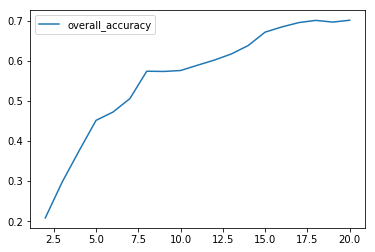

In [55]:
overall_accuracy_k_means_DF.plot()

Accuracy improves as the number of clusters increases. Clusters therefor become more homogenous as we increase the number of clusters because each cluster becomes smaller and more tightly formed. 

## k-Means and number of Principal Components
Clustering should perform just as well using 10 or 50 principal components as it does using 100 or 700 principal components

Let's test this hypothesis:

In [61]:
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

In [62]:
k_means_inertia = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784], columns=['inertia'])

overall_accuracy_kmeans_DF = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784], columns=['overall_accuracy'])

In [ ]:
## Takes a while to run
# for cutoff_numbers in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
#     kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, n_jobs=n_jobs)
    
#     cutoff = cutoff_numbers # looping through number of PCs
    
#     kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    
#     k_mean_inertia.loc[cutoff] = kmeans.inertia_
    
#     X_train_kmeans_clustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
#     X_train_kmeans_clustered = pd.DataFrame(data=X_train_kmeans_clustered, index=X_train.index, columns=['cluster'])
    
#     count_by_cluster_kmeans, count_by_label_kmeans, count_most_freq_kmeans, accuracy_df_kmeans, overall_accuracy_kmeans, accuracy_by_label_kmeans = analyze_cluster(X_train_kmeans_clustered, y_train)
    
#     overall_accuracy_kmeans_DF.loc[cutoff] = overall_accuracy_kmeans
    
# overall_accuracy_kmeans.plot()

If you were to conduct an experiment measuring k-Means accuracy with reduced dimensions not via PCA (or other strong dimensionality reduction methods), you will notice that the accuracy is drastically lower with fewer dimensions. 

That is to say, PCA is a powerful algorithm as we maintain ~70 accuracy from 10 to 784 Principal components. 

That is, with just 10 dimensions (PCA), we can achieve just as great performance via k-Means. Which is much more efficient in terms of memory and speed to process.

# Hierarchical Clustering
We choose how many clusters we would like after hierchical clustering has finished running (opposed to initializing clusters). 

The hierarchical clustering algorithm will build a *dendrogram*, which can be depicted as an upside-down tree. 

The 'leaves' at the very bottom of the tree are individual instances in the dataset. Hierarchical clustering then joins the leaves together - as you move up the tree. 

The instances that are most similar to each other are joined sooned, while instances that are not as similar are joined later. 

Once the algorithm is finished running, we can view the dendrogram and determine where we want to cut the tree, the lower we cut, the more individual branches we are left with. 

## Agglomerative Hierarchical Clustering
We will use *fastcluster* which is a C++ library with an interface in Python/SciPy 

In [68]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

In [70]:
cutoff = 100
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], method="ward", metric="euclidean")
Z_df = pd.DataFrame(data=Z,columns=['cluster_one','cluster_two','distance','new_cluster_size'])

In [71]:
Z_df.head()

,cluster_one,cluster_two,distance,new_cluster_size
0,42194.0,43025.0,0.567125,2.0
1,28350.0,37674.0,0.592486,2.0
2,26696.0,44705.0,0.623957,2.0
3,12634.0,32823.0,0.627941,2.0
4,24707.0,43151.0,0.639227,2.0


In [72]:
Z_df.tail()

,cluster_one,cluster_two,distance,new_cluster_size
49994,99979.0,99987.0,294.200536,14125.0
49995,99992.0,99994.0,384.078068,24315.0
49996,99991.0,99995.0,417.949135,29797.0
49997,99988.0,99996.0,469.968421,34720.0
49998,99993.0,99997.0,498.441848,50000.0


## Evaluating the Clustering Results
Now that we have the dendrogram in place, let's determine where to cut off the dendrogram to make the number of clusters we desire. 

We will select 20 clusters to compare the hierarchical clustering with k-means. 

We will then use the clustering accuracy metric to judge how homogenous the hierarchical clustering clusters are. 

To get exactly 20 clusters, we need to experiment with the distance threshold, which can be done via ```fcluster``` library. 

In [74]:
from scipy.cluster.hierarchy import fcluster

In [85]:
distance_threshold = 168
clusters = fcluster(Z, distance_threshold, criterion="distance")

X_train_hier_clustered = pd.DataFrame(data=clusters, index=X_train_PCA.index, columns=['cluster'])

In [86]:
# how many clusters?
print(f"Number of distinct clusters: {len(X_train_hier_clustered['cluster'].unique())}")

Number of distinct clusters: 20


In [87]:
# Evaluating results
count_by_cluster_hierCluster, count_by_label_hierCluster, count_most_freq_hierCluster, accuracy_DF_hierCluster, overall_accuracy_hierCluster, accuracy_by_label_hierCluster = analyze_cluster(X_train_hier_clustered, y_train)

In [88]:
print(f"Overall accuracy from hierachical clustering: {overall_accuracy_hierCluster}")

Overall accuracy from hierachical clustering: 0.75482


### Real-Life Example:
We would first apply dimensionality reduction (such as PCA), then we would perform clusterting (k-means, hierarchical), and finally we would hand label a few points per cluster. 

For example: for an mnist dataset, if we did not have any labels, we would look at a few images per cluster and label those images based on the digits they displayed. 

So long as the clusters were homogenous enough, the few hand labels we generated could be applied automatically to all the other images in the cluster. 

## DBSCAN
*density-based spatial clustering of applications with noise*. This clustering algorithm groups based on the density of points. 

DBSCAN will group together closely packed points, where close together is defined as a minimum number of points that must exist within a certain distance. 

If the point is within distance of multiple clusters, it will be grouped with the cluster to which it is most densely located. 

Any instance that is not within this certain distance of another cluster is labeled as an outlier. 

DBSCAN is much less prone to distortion typically caused by outliers in the data. 

In [89]:
from sklearn.cluster import DBSCAN

In [90]:
eps = 3 # minimum distance
min_samples = 5
leaf_size = 30
n_jobs = 4

In [91]:
db = DBSCAN(eps=eps,min_samples=min_samples,leaf_size=leaf_size,n_jobs=n_jobs)

In [92]:
cutoff = 99

X_train_PCA_dbscan_clustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscan_clustered = pd.DataFrame(data=X_train_PCA_dbscan_clustered, index=X_train.index, columns=['cluster'])

count_by_cluster_dbscan, count_by_label_dbscan, count_most_freq_dbscan, accuracy_DF_dbscan, overall_accuracy_dbscan, accuracy_by_label_dbscan = analyze_cluster(X_train_PCA_dbscan_clustered, y_train)

In [93]:
overall_accuracy_dbscan

0.242